In [39]:
import torch
from torch import nn 
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

<span style="color: red">**NOTE**</span>: The content of this notebook is based on the free course [Zero to Mastery: Learn PyTorch for Deep Learning](https://www.learnpytorch.io/01_pytorch_workflow/), with some personal modifications and additional explanations.


# From data to model deployment: the PyTorch workflow

In the first notebook, `introduction-to-tensors`, we discussed the concept of tensors and explored the main methods and functions used to manipulate them. We can now move on to how tensors—and the PyTorch library more broadly—can be used to define, train, and evaluate machine learning models. We'll start with the basics, using the simplest machine learning model: linear regression. The goal here is not to explain linear regression itself in detail, but rather to demonstrate how a typical machine learning **workflow** can be implemented using PyTorch—from the initial train/test split to model deployment.

In [40]:
# define parameter
m = .5
b = .3

In [41]:
# Synthetically creating data
a = 0
b = 1 
step = 0.01

X = torch.arange(a, b, step).unsqueeze(dim=1)

In [42]:
X.shape

torch.Size([100, 1])

We defined the `X` tensor, storing the X values of our linear function. As for the y values:

In [43]:
# The linear function
y = m * X + b

`X` and `y` represent the initial data: `X` are the feature values, while `y` is the target variable. Our goal is to learn a regression model, i.e learn the parameters `m` and `b` which define the relationship between features and labels (y). 

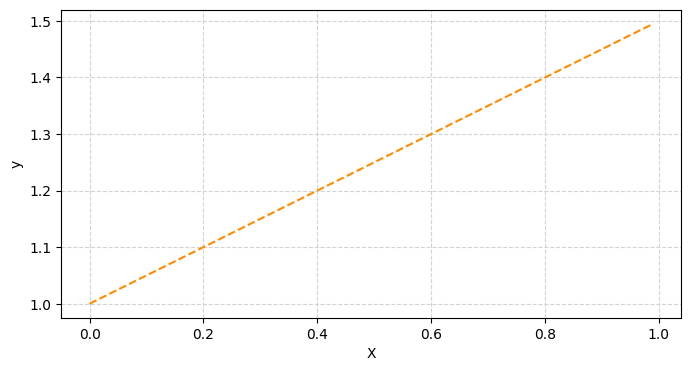

In [44]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(X.numpy(), y.numpy(), linestyle="--", color="darkorange")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.grid(True, linestyle="--", c="lightgray")

## Data Preparation

Before building a model, we need to split our data into three datasets:

- **Training set**: This dataset is used to train the model, i.e., to learn the model parameters. Typically, 60–80% of the original dataset is used for training.
- **Validation set**: This dataset is used to tune the model, i.e., to adjust the hyperparameters that the model depends on in order to achieve the best performance according to a chosen metric (e.g., accuracy). The validation set is not always used, but when it is, it usually represents around 10–20% of the original dataset.
- **Test set**: This dataset is used to evaluate the model after the training phase. It typically accounts for 10–20% of the original dataset.

In [45]:
# A function to split the dataset 
def line_train_test_split(X, y, p: float = 0.80):

    # Define the train split
    train_split = int(p * len(X))

    X_train, y_train = X[:train_split], y[:train_split]
    X_test, y_test = X[train_split:], y[train_split:]

    return X_train, y_train, X_test, y_test

In [46]:
X_train, y_train, X_test, y_test = line_train_test_split(X, y)

## A Linear Regression model in PyTorch

Let’s now build a linear regression model to learn the relationship between `X` and `y`. While we could use the linear regression implementation from scikit-learn, the goal here is to demonstrate how a similar model can be built using PyTorch. We'll first write out the complete code and then go through each part in detail.

In [47]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad = True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad = True)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Linear regression formula
        return self.weights * x + self.bias

First of all, we defined a class called `LinearRegressionModel`, which inherits from `nn.Module`. In PyTorch, almost everything is based on `nn.Module`. The nn module (short for neural networks) contains all the building blocks needed for deep learning models. `Module` is the base class for constructing any neural network. When creating a custom model, we define a class that extends `Module`. **<span style="color: red">This base class requires the implementation of a `forward` method, which specifies the computation to be performed on the input data</span>**.

The `nn.Parameter` class is used to store tensors that should be treated as learnable parameters within a model. If `requires_grad` is set to True, PyTorch will automatically compute gradients for these parameters during backpropagation—one of the major advantages of using PyTorch tensors.

In [48]:
# Check a PyTorch model
torch.manual_seed(42)

In [49]:
# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
lr_model = LinearRegressionModel()

In [50]:
# Check the nn.Parameter(s) within the nn.Module subclass we created
list(lr_model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state of the model, i.e. what the model "contains", using:

In [51]:
lr_model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

`weights` and `bias` have been initialized as random tensors. 

### Making a prediction

As mentioned earlier, when we pass data to the model, it is processed through the `forward` method. To obtain the predicted values (i.e., perform inference), we need to set the model to inference mode. This is done using `torch.inference_mode()`, which is a Python *context manager*:

In [52]:
with torch.inference_mode():
    y_preds = lr_model(X_train)

In [53]:
y_preds[0]

tensor([0.1288])

Naturally, the values produced at this stage will be quite poor and far from the true target values, since we haven’t optimized the model parameters yet—we’re simply making predictions based on randomly initialized parameters. In fact:

In [54]:
# The predicted value is simply the one obtained by passing the values in the forward formula 
X_train[0]*lr_model.weights + lr_model.bias

tensor([0.1288], grad_fn=<AddBackward0>)

Let's plot the test and predicted values for comparison:

In [55]:
with torch.inference_mode():
    y_predictions = lr_model(X_test)

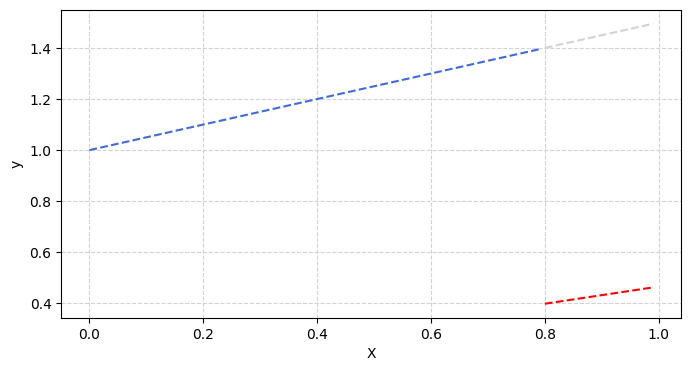

In [56]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(X_train.numpy(), y_train.numpy(), linestyle="--", color="royalblue", label="Training")
ax.plot(X_test.numpy(), y_test.numpy(), linestyle="--", color="lightgrey", label="Test")
ax.plot(X_test.numpy(), y_predictions.numpy(), linestyle="--", color="red", label="Prediction")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.grid(True, linestyle="--", c="lightgray")

Of course, as expected, our predictions are very bad, because so far we have just initialized at random the learning parameters. We need to update these parameters so that they can better represent the data. In other words, we need to *train* our model.

### Train the model

To train a model in PyTorch, we need to introduce two additional components:

- **Loss function**: a function that measures how far our model’s predictions are from the true values, i.e., how much the predicted outputs differ from the targets.  
- **Optimizer**: the algorithm that updates the model’s internal parameters in order to minimize the loss.

PyTorch provides built-in implementations of both loss functions and optimizers. For loss functions, the most commonly used are **Mean Absolute Error (MAE)** for regression and **Binary Cross-Entropy (BCE)** for classification problems. Since we are training a linear regression model, we will use **MAE**, which is defined as:

$$
MAE = \frac{1}{N} \sum_{i=1}^N |y_p^{(i)} - y_t^{(i)}|
$$

where $y_p$ are the predicted values and $y_t$ are the true values.  

As for optimizers, two of the most widely used are **Stochastic Gradient Descent (SGD)** and the **Adam optimizer**. At the end of this notebook, we will cover the mathematical details of these optimization methods. For now, let’s see how to apply them in PyTorch to train our linear regression model.


In [57]:
# L1Loss is MAE in PyTorch
lr_loss = nn.L1Loss()

In [58]:
# Create the optimizer
lr_optimizer = torch.optim.SGD(
    params = lr_model.parameters(),
    lr=0.01
)

We are using the *Stochastic Gradient Descent* optimizer, which is defined in PyTorch with `torch.optim.SGD()`. This built-in function takes two main arguments:

1. `params`: the model parameters to optimize;  
2. `lr`: the **learning rate**, which controls the step size of each update. Higher values correspond to larger updates, while lower values correspond to smaller updates.  

If the learning rate is too high, the optimizer may fail to converge; if it is too low, the training process can become very slow. The learning rate is a **hyperparameter**, meaning it must be chosen and set manually by the machine learning engineer.

Below, the full code to train and test the model. Let's run it and then discuss it step-by-step:

In [59]:
# Set the number of epochs: how many times the model will pass over the training data
epochs = 1000

In [60]:
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

In [61]:
# TRAINING LOOP
torch.manual_seed(42)

for epoch in range(epochs):
    ### TRAINING

    # This command put the model in training mode
    lr_model.train()

    # 1. Pass the training data through the forward() method of the model
    y_pred = lr_model(X_train)

    # 2. Calculate the loss between predicted and true values
    loss = lr_loss(y_pred, y_train)

    # 3. Zero grad of the optimizer --> we zero the gradients since they accumalate at each epochs
    lr_optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Progress the optimizer
    lr_optimizer.step()

    ### TESTING
    # Put the model in evaluation mode
    lr_model.eval()

    # Make the inference
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = lr_model(X_test)

        # 2. Caculate loss on test data
        # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type
        test_loss = lr_loss(test_pred, y_test.type(torch.float)) 

        # Print out what's happening 
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().item())
            test_loss_values.append(test_loss.detach().item())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.9356979131698608 | MAE Test Loss: 1.0038174390792847 
Epoch: 10 | MAE Train Loss: 0.8200953602790833 | MAE Test Loss: 0.8684649467468262 
Epoch: 20 | MAE Train Loss: 0.7044928669929504 | MAE Test Loss: 0.7331124544143677 
Epoch: 30 | MAE Train Loss: 0.588890552520752 | MAE Test Loss: 0.597760021686554 
Epoch: 40 | MAE Train Loss: 0.47328799962997437 | MAE Test Loss: 0.4624076783657074 
Epoch: 50 | MAE Train Loss: 0.3576856553554535 | MAE Test Loss: 0.3270552456378937 
Epoch: 60 | MAE Train Loss: 0.24208326637744904 | MAE Test Loss: 0.19170284271240234 
Epoch: 70 | MAE Train Loss: 0.1264808475971222 | MAE Test Loss: 0.05635044723749161 
Epoch: 80 | MAE Train Loss: 0.03413804620504379 | MAE Test Loss: 0.05251990631222725 
Epoch: 90 | MAE Train Loss: 0.027357865124940872 | MAE Test Loss: 0.06144831329584122 
Epoch: 100 | MAE Train Loss: 0.023902876302599907 | MAE Test Loss: 0.05483921617269516 
Epoch: 110 | MAE Train Loss: 0.020475853234529495 | MAE Test Loss:

A training and test loop in PyTorch works as follows. For each epoch (i.e., one pass over the training data):

- `model.train()`: switch the model to **training** mode (layers like dropout and batch norm use their training behavior).
- `model(X_train)`: pass `X_train` through the model’s `forward` method. This produces the current predictions/outputs for the training data.
- `loss(...)`: compute the loss between the predictions and the ground-truth targets.
- `optimizer.zero_grad()`: clear (zero) all parameter gradients. Gradients accumulate by default across backward passes, so we reset them before computing new ones.
- `loss.backward()`: run reverse-mode automatic differentiation. PyTorch traverses the computation graph built during the forward pass and computes $\partial L/\partial \theta$ for every parameter `θ` with `requires_grad=True`. These gradients are accumulated into each parameter’s `.grad` buffer (they are not applied yet).
- `optimizer.step()`: take one optimization step (e.g., SGD, Adam), updating the model parameters using the gradients stored in their `.grad` buffers.
- `model.eval()`: switch the model to **evaluation** mode (dropout/batch norm use inference behavior), then compute predictions on the test set—typically inside a `with torch.no_grad():` block to disable gradient tracking.

To be more precise, what we are doing with this loop is:

1. During the **forward pass**, the model takes the input data and produces predictions based on its current parameters (weights and biases).
2. The **loss function** measures how far these predictions are from the true targets.
3. When we call `loss.backward()`, PyTorch applies **backpropagation**: it traverses the computation graph in reverse and computes the partial derivatives of the loss with respect to each parameter. In other words, it tells us *how much* and in *which direction* each weight should be adjusted to reduce the error. These values are stored in the `.grad` attribute of each parameter tensor.
4. Finally, `optimizer.step()` uses these gradients to actually update the model’s parameters. For example, in stochastic gradient descent (SGD), each parameter is moved a small step in the opposite direction of the gradient, scaled by the learning rate: $$\theta \leftarrow \theta - \eta \frac{\partial L }{\partial \theta}$$ More advanced optimizers like Adam use the same gradients but apply additional heuristics (momentum, adaptive learning rates, etc.).

In summary:
- `loss.backward()` **computes the gradients** but does not change the parameters.
- `optimizer.step()` **updates the parameters** using those gradients.

We can collect both training and test loss values and plot them. In a well-behaved run, both curves tend to go down over epochs as the optimizer refines the weights and biases (if test loss rises while training loss falls, that may indicate overfitting).


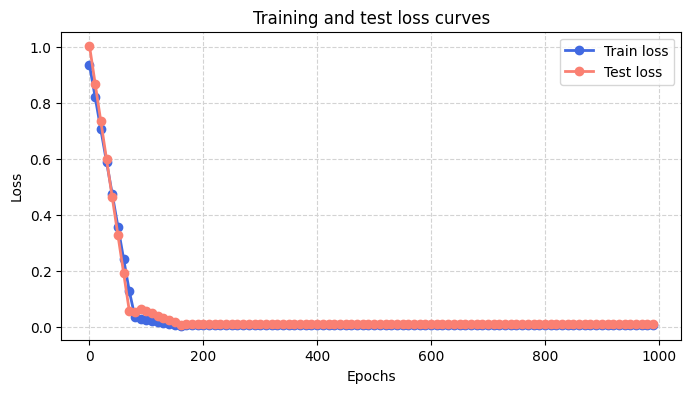

In [62]:
# Plot the loss curves
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(epoch_count, train_loss_values, label="Train loss", color="royalblue", linewidth=2, marker="o")
ax.plot(epoch_count, test_loss_values, label="Test loss", color="salmon", linewidth=2, marker="o")
ax.set_title("Training and test loss curves")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")

ax.grid(True, linestyle="--", color="lightgrey")
ax.legend()
plt.show()

### Make predictions with a trained model

Once we have trained the model, we can make predictions with it. Again:

In [63]:
# 1. Set the model in evaluation mode
lr_model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_final_pred = lr_model(X_test)

In [64]:
y_final_pred

tensor([[1.3953],
        [1.4003],
        [1.4054],
        [1.4104],
        [1.4155],
        [1.4205],
        [1.4255],
        [1.4306],
        [1.4356],
        [1.4406],
        [1.4457],
        [1.4507],
        [1.4557],
        [1.4608],
        [1.4658],
        [1.4708],
        [1.4759],
        [1.4809],
        [1.4859],
        [1.4910]])

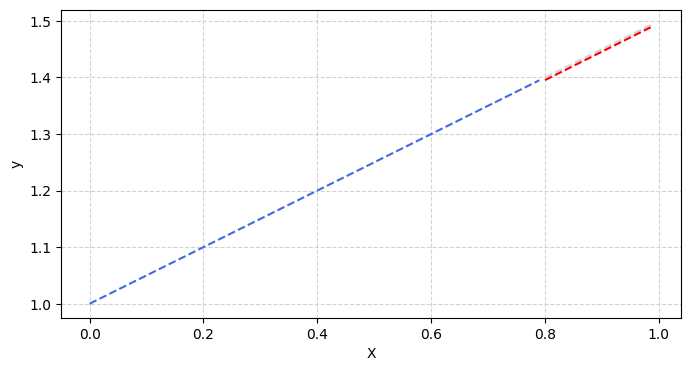

In [65]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(X_train.numpy(), y_train.numpy(), linestyle="--", color="royalblue", label="Training")
ax.plot(X_test.numpy(), y_test.numpy(), linestyle="--", color="lightgrey", label="Test")
ax.plot(X_test.numpy(), y_final_pred.numpy(), linestyle="--", color="red", label="Prediction")
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.grid(True, linestyle="--", c="lightgray")

We can see that now our predictions are far better than before! There is one extra thing we need to remember when making predictions with a PyTorch model: **<span style="color: red"> all predictions should be made with objects on the same device, e.g. data and model on GPU only or on CPU only.</span>** Here, we haven't setup device-agnostic code yet hence both data and model are by default on CPU.

### Save and Load the model

Once we have trained a model and are satisfied with its performance, it is often desirable to save it so that we can later reload it in another environment without having to retrain from scratch.  
The recommended best practice in PyTorch is to save the model’s `state_dict` rather than the entire model object.  

As the PyTorch documentation explains, saving the full model has a major drawback:  

> *The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. Because of this, your code can break in various ways when used in other projects or after refactoring.*

For this reason, <span style="color:red">the preferred approach is to save only the model’s **state dictionary**, which contains all the learnable parameters (weights and biases) of the model, but is independent of the surrounding code structure.</span>

Let’s see how to save and load a model’s state dictionary:

In [66]:
# 1. Create models directory 
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
model_name = "01_pytorch_lr_model1.pth"
model_save_path = model_path / model_name

# 3. Save the model state dict 
print(f"Saving model to: {model_save_path}")
torch.save(obj=lr_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: models/01_pytorch_lr_model1.pth


To load the saved model we need to:
1. create a new instance of the model class
2. load the `state_dict` using `load_state_dict`

In [67]:
# New instance
loaded_model = LinearRegressionModel()

In [68]:
# load the state dict
loaded_model.load_state_dict(torch.load(f=model_save_path))

/var/folders/xh/7gjfwn1156386st5775zf6cc0000gn/T/ipykernel_9585/2937666412.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=mode

<All keys matched successfully>

In [69]:
# 1. making predictions with loaded model
loaded_model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_loaded_pred = loaded_model(X_test)

In [70]:
y_loaded_pred

tensor([[1.3953],
        [1.4003],
        [1.4054],
        [1.4104],
        [1.4155],
        [1.4205],
        [1.4255],
        [1.4306],
        [1.4356],
        [1.4406],
        [1.4457],
        [1.4507],
        [1.4557],
        [1.4608],
        [1.4658],
        [1.4708],
        [1.4759],
        [1.4809],
        [1.4859],
        [1.4910]])

## Extra: the SDG and Adam optimizers

We have seen that one essential ingredient in training a model (not necessarily a PyTorch model) is the *optimizer*. An optimizer is an algorithm that updates the parameters of the model in order to minimize the loss. Let’s take a closer look at the math behind the most common optimizers.  

In general, suppose we have a model with a parameter vector $\boldsymbol{\theta}$ of dimension $N$. For each choice of parameter values, the loss function $L(\boldsymbol{\theta})$ will take on some value. In other words, $L(\boldsymbol{\theta})$ defines a hypersurface in the $N$-dimensional parameter space. Optimization begins by picking an initial set of parameters (often at random) and evaluating the loss. The goal is then to move across this hypersurface to search for minima (ideally the global minimum).  

The simplest approach is to compute the *gradient* of the loss with respect to the parameters. The gradient vector points in the direction of steepest increase, so a natural way to reduce the loss is to update parameters in the *opposite* direction:  

$$
\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \nabla_{\theta} L
$$  

Here, $\eta$ is the **learning rate**. It is a scalar that controls the step size: a higher learning rate can speed up convergence but also risks overshooting minima, while a too small learning rate can make convergence extremely slow. This method is known as **stochastic gradient descent (SGD)**.  

A more advanced and widely used algorithm is **Adam** (*adaptive moment estimation*), first introduced by Kingma and Ba in their influential paper *"Adam: A Method for Stochastic Optimization"*. Adam combines ideas from both SGD with momentum and RMSProp. In particular, it keeps track of **exponentially weighted moving averages of past gradients (the first moment)** and **squared gradients (the second moment)**. This allows Adam to adapt the learning rate for each parameter individually, making training more stable and often faster.  

In simplified form, Adam updates parameters at time $t$ according to:  

$$
\boldsymbol{\theta}_{t+1} \gets \boldsymbol{\theta}_t - \eta \, \frac{\hat{\boldsymbol{m}}_t}{\sqrt{\hat{\boldsymbol{v}}_t} + \epsilon}
$$  

where:  
- $\boldsymbol{m}_t$ is the exponentially weighted moving average of past gradients (the **first moment**), updated as  
  $$
  \boldsymbol{m}_t = \beta_1 \boldsymbol{m}_{t-1} + (1-\beta_1) \nabla_{\theta_t} L
  $$  
- $\boldsymbol{v}_t$ is the moving average of squared gradients (the **second moment**),  
- $\beta_1$ and $\beta_2$ are hyperparameters controlling the decay rates (commonly $\beta_1 = 0.9$, $\beta_2 = 0.999$),  
- $\hat{\boldsymbol{m}}_t$ and $\hat{\boldsymbol{v}}_t$ are bias-corrected estimates,  
- $\epsilon$ is a small constant added for numerical stability.  

In practice, the key intuition is:  
- **SGD** takes steps proportional to the raw gradient.  
- **Adam** smooths gradients over time and scales updates per-parameter, often leading to faster and more robust convergence in deep learning.  
